#  Homework 4 - Berkeley STAT 157

**Your name: XX, SID YY, teammates A,B,C** (Please add your name, SID and teammates to ease Ryan and Rachel to grade.)

Handout 2/12/2019, due 2/19/2019 by 4pm in Git by committing to your repository.

In this homework, we will build a model based real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). This notebook contains codes to download the dataset, build and train a baseline model, and save the results in the submission format. Your jobs are 

1. Developing a better model to reduce the prediction error. You can find some hints on the last section. 

2. Submitting your results into Kaggle and take a sceenshot of your score. Then replace the following image URL with your screenshot.

![](score.png)

We have two suggestions for this homework:

1. Start as earlier as possible. Though we will cover this notebook on Thursday's lecture, tuning hyper-parameters takes time, and Kaggle limits #submissions per day.
2. Work with your project teammates. It's a good opportunity to get familiar with each other. 

Your scores will depend your positions on Kaggle's Leaderboard. We will award the top-3 teams/individuals 500 AWS credits.

## Accessing and Reading Data Sets

The competition data is separated into training and test sets. Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition. The data includes multiple datatypes, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.; Some data is missing and is thus labeled 'na'. The price of each house, namely the label, is only included in the training data set (it's a competition after all). The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`, an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/). Make sure you have `pandas` installed for the experiments in this section.

In [2]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import pandas as pd


#下面的包是我加的
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# 这只是为了一下显示100列，不会被折叠，忽略这段代码
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

We downloaded the data into the current directory. To load the two CSV (Comma Separated Values) files containing training and test data respectively we use Pandas.

In [155]:
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_train.csv')
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_test.csv')
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

The training data set includes 1,460 examples, 80 features, and 1 label., the test data contains 1,459 examples and 80 features.

In [5]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [6]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


### [Kaggle Tutorial](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
### [知乎](https://zhuanlan.zhihu.com/p/39429689)

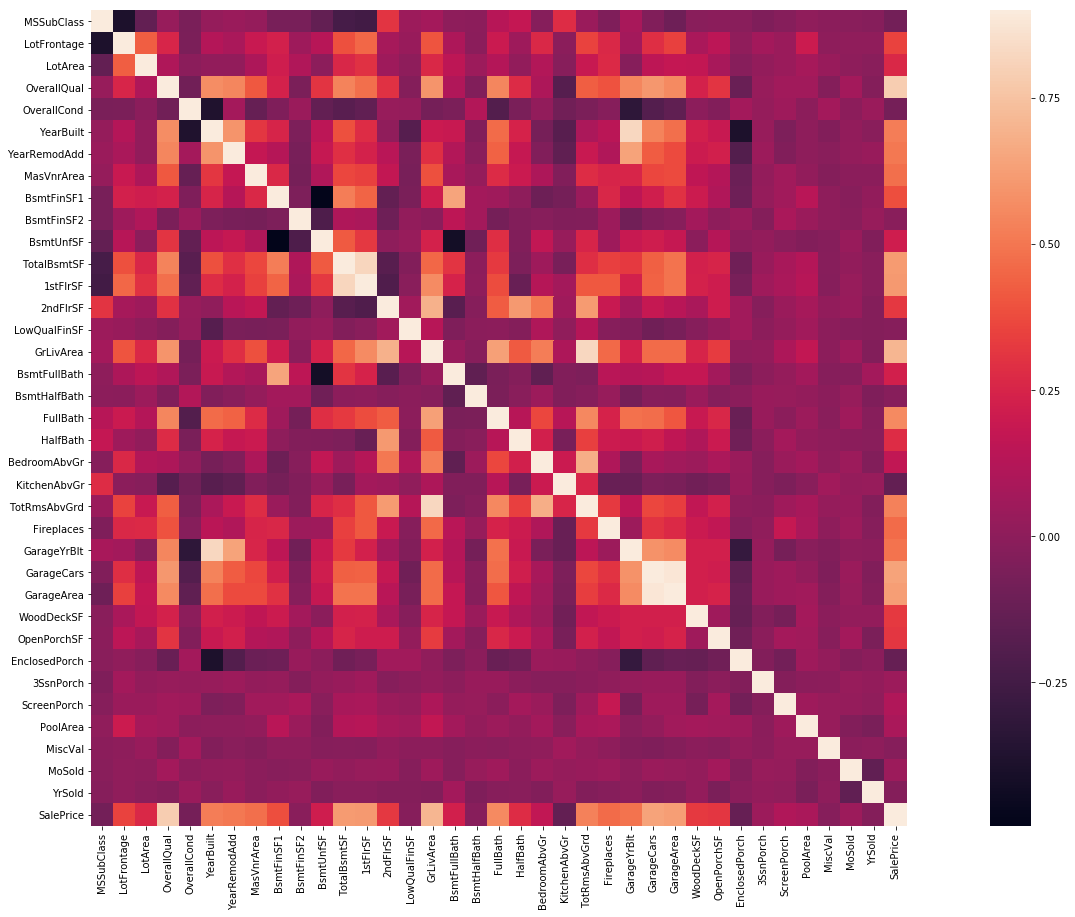

In [7]:
# 相关性分析
corrmat = train_data.iloc[:, 1:].corr()
plt.subplots(figsize=(30,15))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [8]:
corrmat['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

### 相关性分析结论 - 明显线性相关的：  
变量描述看这里： https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data   
* YearBuilt - Garage Year Built   
* GrLivArea: Above grade (ground) living area square feet - TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)   
* Garage Cars - Garage Area    
* TotalBsmtSF: Total square feet of basement area（基地面积） - 1stFlrSF: First Floor square feet（一层面积）   
----------------------------------------------------------------------------------------------
<big>   
* 因为相互之间高相关性，去掉了all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond', 'BsmtUnfSF'], axis=1)（比较黑的和非常淡的）
     
* 又因为和salesprice的相关性太低，去掉了'LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch', 'PoolArea'

We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [203]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features = all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond', 'BsmtUnfSF'], axis=1)
all_features = all_features.drop(['LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'PoolArea'], axis=1)
all_features = all_features.reset_index(drop=True)
print(all_features.shape)
all_features.head(5)

(2919, 68)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,548.0,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,460.0,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,608.0,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,642.0,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,836.0,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,12,2008,WD,Normal


## 年份相减，新建变量为YearsSinceRemodel，指房子的年龄（然后把'YrSold','MoSold','YearBuilt','YearRemodAdd'变量删掉了）

In [204]:
#先在这里处理一下年份
all_features['YearsSinceRemodel'] = all_features['YrSold']- all_features['YearRemodAdd']
all_features = all_features.drop(['YrSold','MoSold','YearBuilt','YearRemodAdd'], 1)
print(all_features.shape)
all_features.head(5)

(2919, 65)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearsSinceRemodel
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,548.0,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,WD,Normal,5
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,460.0,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,WD,Normal,31
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,608.0,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,WD,Normal,6
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,642.0,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,WD,Abnorml,36
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,836.0,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,WD,Normal,8


## Data Preprocessing

As stated above, we have a wide variety of datatypes. Before we feed it into a deep network we need to perform some amount of processing. Let's start with the numerical features. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

To check that this transforms $x$ to data with zero mean and unit variance simply calculate $\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$. To check the variance we use $\mathbf{E}[(x-\mu)^2] = \sigma^2$ and thus the transformed variable has unit variance. The reason for 'normalizing' the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

### 缺失值：   
<big>  
PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage不应该被包含进模型里（或者加一个变量missing）。   
* Garage同一批数据缺失，GarageYearBuilt不需要包括。  
* Basement同一批数据缺失
* Masonry（查了字典这个词是石工？？家里的大理石？？？）同一批数据缺失   
* 所有那些只有一条数据缺失的解决办法：   
    1）取众数/上一值/下一值（方法一），    
    2）把这个observation删掉（如果只有一个observation）？？？
    
-------------------------------------------------------------------------------
下面找出了缺失值较多的变量   

In [158]:
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(65)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageFinish,159,0.054471
GarageType,157,0.053786


## 删掉了前6个feature，对Garage和Basement这些feature（应该是同一组数据，159和82这些）新建一个missing class     
## 对于缺失只有1，或者2个observation的feature，我删掉了train data里的observation（index 1379），补全了test data里的（补了missing和mode，这一步值得推敲，到底对test data的缺失值补什么）

In [205]:

def fill_missings(res):
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna('missing')
    res['GarageQual'] = res['GarageQual'].fillna('missing')
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    
    res['BsmtQual'] = res['BsmtQual'].fillna('missing')
    res['BsmtCond'] = res['BsmtCond'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna('missing')
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    
    res['MSZoning'] = res['MSZoning'].fillna('missing')
    res['BsmtFullBath'] = res['BsmtFullBath'].fillna(res['BsmtFullBath'].mode()[0])
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])   
    res['BsmtFinSF1'] = res['BsmtFinSF1'].fillna(0)
    
    
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0]) 
    res["Functional"] = res["Functional"].fillna("Typ")
    res["Electrical"] = res["Electrical"].fillna(res["Electrical"].mode()[0])
    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    res['GarageArea'] = res['GarageArea'].fillna(0)
    
    #对Area用mean填充  
    #res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].fillna(0)
    res['MasVnrType'] = res['MasVnrType'].fillna('missing')
    


    return res
#mydata=fill_missings(my_data)

## 抄来一段特征工程的代码：

In [206]:
def map_values(full):
    
    full["oMSZoning"] = full.MSZoning.map({'missing': 0, 'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'missing':0, 'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'missing':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'missing':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'missing':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'missing':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
    return "Done!"

In [207]:
def transform(X):

        #all_features = all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond', 'BsmtUnfSF', 'EnclosedPorch'], axis=1)
        #all_features = all_features.drop(['LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch', 'PoolArea'], axis=1)
        X["TotalHouse"] =  X["1stFlrSF"] + X["2ndFlrSF"]   
        X["TotalArea"] =  X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
        X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
        X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
        X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
        X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
        X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
        X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
        
        X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
        X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
        X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
        X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
        X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
        X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]

        X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
        X["TotalPlace"] = X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
        return X

## normalize

In [208]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# after standardizing the data all means vanish, hence we can set missing values to 0
#all_features = all_features.fillna(0)
print(all_features.shape)
all_features.head(5)

(2919, 65)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearsSinceRemodel
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.646073,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.523038,Gd,TA,PConc,Gd,TA,No,GLQ,0.580708,Unf,GasA,Ex,Y,SBrkr,-0.773728,1.207172,0.413476,1.086464,0.781232,1.232388,0.169898,-0.207663,Gd,Typ,-0.924153,NaN,Attchd,RFn,0.348780,TA,TA,Y,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,NaN,NaN,NaN,WD,Normal,-0.886857
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,-0.063174,Gable,CompShg,MetalSd,MetalSd,None,-0.569893,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.177709,Unf,GasA,Ex,Y,SBrkr,0.261030,-0.784891,-0.471810,-0.819258,0.781232,-0.756191,0.169898,-0.207663,TA,Typ,0.623525,TA,Attchd,RFn,-0.059772,TA,TA,Y,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,NaN,NaN,NaN,WD,Normal,0.357635
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.646073,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.333448,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.097840,Unf,GasA,Ex,Y,SBrkr,-0.610614,1.235163,0.563659,1.086464,0.781232,1.232388,0.169898,-0.207663,Gd,Typ,0.623525,TA,Attchd,RFn,0.627338,TA,TA,Y,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,NaN,NaN,NaN,WD,Normal,-0.838992
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.646073,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.569893,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.494771,Unf,GasA,Gd,Y,SBrkr,-0.506118,0.978574,0.427309,1.086464,-1.027187,-0.756191,0.169898,-0.207663,Gd,Typ,0.623525,Gd,Detchd,Unf,0.785188,TA,TA,Y,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,NaN,NaN,NaN,WD,Abnorml,0.596961
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,1.355319,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.381770,Gd,TA,PConc,Gd,TA,Av,GLQ,0.468770,Unf,GasA,Ex,Y,SBrkr,-0.037164,1.671364,1.377806,1.086464,0.781232,1.232388,1.385418,-0.207663,Gd,Typ,0.623525,TA,Attchd,RFn,1.685860,TA,TA,Y,0.776834,0.540332,-0.359539,-0.103313,-0.285886,NaN,NaN,NaN,WD,Normal,-0.743261


## 试图分析各个变量的skewness，看看有没有变量要取log的变量（比如偏度>0.15)

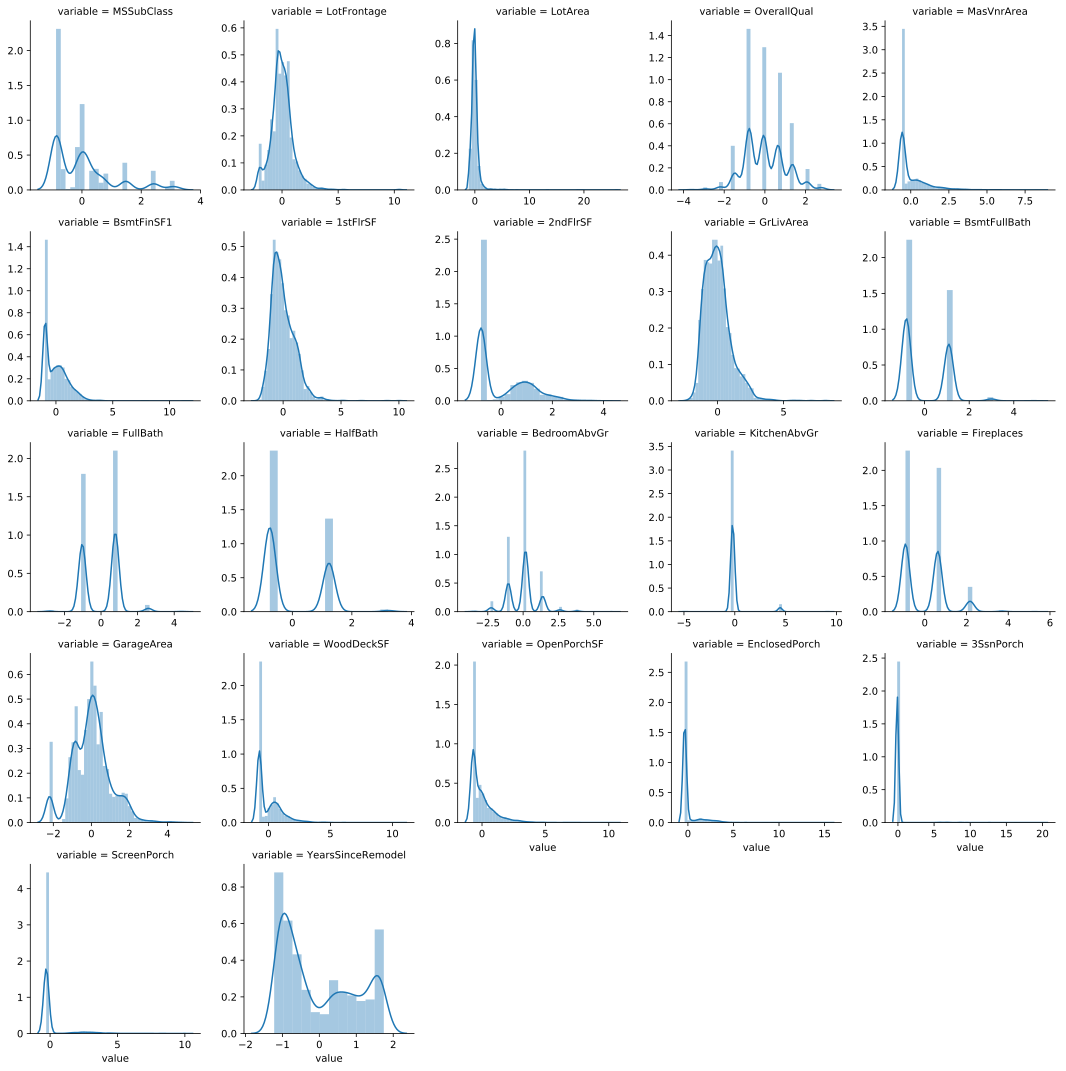

In [162]:
#有哪些要取log的吗……？？？
quantitative = [f for f in all_features.columns if all_features.dtypes[f] != 'object'and all_features.dtypes[f] != 'str']
skewed_feats = all_features[quantitative].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
f = pd.melt(all_features, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

## 删掉missing data多的几个feature(注意这里命名成了all_features2)

In [209]:
all_features2 = all_features.drop((missing_data[missing_data['Total'] > 485]).index,1)
all_features2.shape

(2919, 59)

## 删掉缺失个数小于4的
## 人工把index找出来了……这里1379属于train，其他index属于test

In [127]:

for index in (missing_data[missing_data['Total'] <5].index):
    print(all_features2.loc[all_features2[index].isnull()].index)

Int64Index([1915, 2216, 2250, 2904], dtype='int64')
Int64Index([2120, 2188], dtype='int64')
Int64Index([1915, 1945], dtype='int64')
Int64Index([2216, 2473], dtype='int64')
Int64Index([1555], dtype='int64')
Int64Index([2576], dtype='int64')
Int64Index([2151], dtype='int64')
Int64Index([2151], dtype='int64')
Int64Index([2489], dtype='int64')
Int64Index([1379], dtype='int64')
Int64Index([2120], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype

In [178]:
#dropIndex = [1915, 2216, 2250, 2904, 2120, 2188, 1945, 2473, 2151, 2489, 1379, 1555, 2576]
#属于train的有：1个，
#属于test的有: 12个
#for index in dropIndex:
    #all_features3.iloc[index,:] = all_features3.iloc[index,:].fillna()


## 把1379drop掉，这里新建了all_features3

In [210]:
all_features3 = all_features2.drop(1379)
all_features3.shape

(2918, 59)

## 调用之前定义的函数把缺失值补全，新建all_feature4

In [211]:
all_features4 = fill_missings(all_features3)
all_features4.shape

(2918, 59)

### 检查缺失值是不是没有了

In [212]:
all_features4.isnull().sum().max()

0

Next we deal with discrete values. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

In [213]:
map_values(all_features4)

transform(all_features4)
all_features4.head()
print(all_features4.shape)

(2918, 96)


In [214]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates an indicative feature for it.
# mli 是（2919，354）
all_features4 = pd.get_dummies(all_features4, dummy_na=True)
all_features4.shape

(2918, 342)

In [215]:
all_features4.head(5)

,MSSubClass,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,YearsSinceRemodel,oMSZoning,oNeighborhood,oCondition1,oBldgType,oHouseStyle,oExterior1st,oMasVnrType,oExterQual,oFoundation,oBsmtQual,oBsmtExposure,oHeating,oHeatingQC,oKitchenQual,oFunctional,oGarageType,oGarageFinish,oPavedDrive,oSaleType,oSaleCondition,TotalHouse,TotalArea,+_TotalHouse_OverallQual,+_GrLivArea_OverallQual,+_oMSZoning_TotalHouse,+_oMSZoning_OverallQual,+_oNeighborhood_TotalHouse,+_oNeighborhood_OverallQual,+_BsmtFinSF1_OverallQual,-_oFunctional_TotalHouse,-_oFunctional_OverallQual,-_LotArea_OverallQual,-_TotalHouse_LotArea,-_oCondition1_TotalHouse,-_oCondition1_OverallQual,PorchArea,TotalPlace,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_missing,MSZoning_nan,Street_Grvl,Street_Pave,Street_nan,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_missing,Utilities_nan,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_missing,MasVnrType_nan,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_missing,BsmtQual_nan,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_missing,BsmtCond_nan,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_missing,BsmtExposure_nan,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType

In [217]:
all_features4.isnull().sum().max()

0

In [218]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
all_features4 = pd.DataFrame(pca.fit_transform(all_features4))

## 这边Log SalesPrice了.

You can see that this conversion increases the number of features from 79 to 331. Finally, via the `values` attribute we can extract the NumPy format from the Pandas dataframe and convert it into MXNet's native representation - NDArray for training.

### train_data2 = train_data.drop([1379]) 新建train_data2是为了drop label 1379   
### 同时normalize了SalePrice

In [219]:
n_train = train_data.shape[0]
train_features = nd.array(all_features4[:(n_train-1)].values)
test_features = nd.array(all_features4[(n_train-1):].values)
train_data2 = train_data.drop([1379])
#test_data2 = test_data.drop([455, 756, 790, 1444,660, 728,485,1013,691,1029,95,1116])
#train_data2['SalePrice'] = (train_data2['SalePrice'] - train_data2['SalePrice'].mean())/train_data2['SalePrice'].std()

### SalePrice取log

In [220]:
temp = nd.array(train_data2.SalePrice.values).reshape((-1, 1))
#print(temp)
#train_label log化(不会取log)
train_labels = temp.log()
print(train_labels)


[[12.247694]
 [12.109011]
 [12.317166]
 ...
 [12.49313 ]
 [11.864462]
 [11.901584]]
<NDArray 1459x1 @cpu(0)>


## Training

To get started we train a linear model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

In [221]:
loss = gloss.L2Loss()
def get_net(drop_prob1):
    net = nn.Sequential()
    net.add(nn.Dense(64, activation="relu"),
            # Add a dropout layer after the first fully connected layer
            nn.Dropout(drop_prob1),
            nn.Dense(1, activation="relu"),
            # Add a dropout layer after the second fully connected layer
            #nn.Dropout(drop_prob2),
            #nn.Dense(1)
           )
    net.initialize(init.Normal(sigma=0.01))
    return net

House prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in this competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

In [222]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds, labels).mean())
    return rmse.asscalar()

Unlike in the previous sections, the following training functions use the Adam optimization algorithm.  Compared to the previously used mini-batch stochastic gradient descent, the Adam optimization algorithm is relatively less sensitive to learning rates.  This will be covered in further detail later on when we discuss the details on [Optimization Algorithms](../chapter_optimization/index.md) in a separate chapter.

In [76]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## k-Fold Cross-Validation

The k-fold cross-validation was introduced in the section where we discussed how to deal with [“Model Selection, Underfitting and Overfitting"](underfit-overfit.md). We will put this to good use to select the model design and to adjust the hyperparameters. We first need a function that returns the i-th fold of the data in a k-fold cros-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data. Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

In [77]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [78]:

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size, drop_prob1):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(drop_prob1)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection

We pick a rather un-tuned set of hyperparameters and leave it up to the reader to improve the model considerably. Finding a good choice can take quite some time, depending on how many things one wants to optimize over. Within reason the k-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 0.001, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size, 0)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

You will notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the $K$-fold cross validation may be higher. This is most likely a consequence of overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.

##  Predict and Submit

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

### test_data['SalePrice'] = nd.exp(pd.Series(preds.reshape(1, -1)[0])) 我又exp回来了

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size, drop_prob1):
    net = get_net(drop_prob1)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(test_features).asnumpy()
    # reformat it for export to Kaggle
    test_data['SalePrice'] = nd.exp(pd.Series(preds.reshape(1, -1)[0]))
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Let's invoke the model. A good sanity check is to see whether the predictions on the test set resemble those of the k-fold crossvalication process. If they do, it's time to upload them to Kaggle.

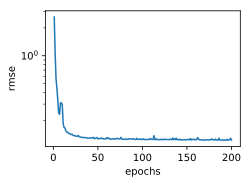

train rmse 0.122414


In [39]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,0)

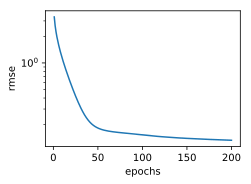

train rmse 0.132668


In [52]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

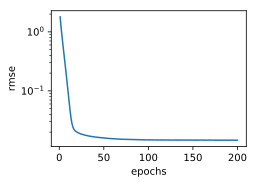

train rmse 0.014634


In [118]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

A file, `submission.csv` will be generated by the code above (CSV is one of the file formats accepted by Kaggle).  Next, we can submit our predictions on Kaggle and compare them to the actual house price (label) on the testing data set, checking for errors. The steps are quite simple:

* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button on the right.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![](kaggle_submit2.png)

## Hints

1. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?
1. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?
1. Improve the score on Kaggle by tuning the hyperparameters through k-fold crossvalidation.
1. Improve the score by improving the model (layers, regularization, dropout).
1. What happens if we do not standardize the continuous numerical features like we have done in this section?

Note for converting this notebook into PDF. If you use 'File -> Download as -> PDF', you may get the error that svg cannot converted because inkscape is not installed and cannot find PNG images. The easiest way is printing this notebook as a PDF in your browser. Or, you can install inkscape to convert SVG (On macOS, you may `brew cask install xquartz inkscape`, on Ubuntu, you may `sudo apt-get install inkscape`) and change the image URL to local filenames. 